In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import datetime
import random
from tqdm import tqdm

import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
import matplotlib.dates as dates
from pandas.plotting import register_matplotlib_converters
from mpl_toolkits.mplot3d import Axes3D

from scipy import signal
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
register_matplotlib_converters()
from time import time
import seaborn as sns
sns.set(style="whitegrid")

from sklearn.preprocessing import StandardScaler,MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest

import warnings
warnings.filterwarnings('ignore')

from IPython.display import display
pd.set_option('display.max_rows', 15)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

RANDOM_SEED = np.random.seed(0)

In [17]:
class IF_smthng:

  def __init__(self, df, prcntg, nrmlz_rng, weight_cnt, weight_rsd, weight_dstn):
    self.df = df
    self.prcntg = prcntg
    self.nrmlz_rng = nrmlz_rng
    self.weight_cnt = weight_cnt
    self.weight_rsd = weight_rsd
    self.weight_dstn = weight_dstn


  def preprocessing(self):
    # 필요없는 검사항목 및 pass/unpass drop
    self.df = self.df.drop(['사업장명', '검사구분', '자재코드', '자재명', '샘플번호', '검사키'], axis=1)
    str_list = ['식별번호 일치여부', '부품 정상조립 여부', '보호피막 처리 누락 및 결함여부', 'S/W 버전 확인_PC전시화면', 'S/W 버전 확인_시험 프로그램', '초기고장배제 진동시험, 온도시험']

    for s in str_list:
        self.df = self.df[self.df['검사항목']!=s]
    self.df = self.df.reset_index(drop=True)

    # 기준규격
    standard = self.df[['상한값', '하한값', '검사항목']][14:28].reset_index(drop=True)
    standard['검사항목'] = ['pe_repeat','pe_head','pe_roll','pe_pitch', 'att_roll', 'att_pitch', 'att_head', 'set_0', 'set_90', 'set_180', 'set_270',  'weight', 'voltage', 'current']
    standard = standard.fillna(0)

    # 검사항목 별 검사값 데이터 형태로 변환
    df_pivot = self.df[['검사요청번호', '검사항목', '검사값']]
    df_pivot = df_pivot.pivot_table(index='검사요청번호', columns='검사항목', values='검사값')
    df_pivot.columns = ['pe_head', 'att_head', 'pe_pitch', 'att_pitch', 'pe_roll', 'att_roll', 'current', 'voltage', 'pe_repeat', 'weight', 'set_0', 'set_180', 'set_90', 'set_270']

    # 시계열 변수 datetime
    df_pivot = df_pivot.reset_index()
    df_pivot['datetime'] = df_pivot['검사요청번호'].str.slice(start=3, stop=11)
    df_pivot['datetime'] = pd.to_datetime(df_pivot['datetime'], format='%Y%m%d')

    # 임의의 datetime 시간 지정
    df_pivot2 = pd.DataFrame()

    for date in df_pivot['datetime'].unique():
      date_i = df_pivot[df_pivot['datetime']==date].reset_index(drop=True).reset_index()
      date_i['index'] = date_i['index'].astype(str)

      date_i['datetime_num'] = date_i['검사요청번호'].str.slice(start=3, stop=11) + '0' + date_i['index']
      df_pivot2 = df_pivot2.append(date_i)

    df_pivot = df_pivot2.drop(['index'], axis=1).reset_index(drop=True)

    df_pivot['datetime_num'] = pd.to_datetime(df_pivot['datetime_num'], format='%Y%m%d%H')
    df_pivot = df_pivot[['pe_head'	,'att_head',	'pe_pitch',	'att_pitch'	,'pe_roll'	,'att_roll',	'current'	,'voltage'	,'pe_repeat',	'weight'	,'set_0'	,'set_180'	,'set_90',	'set_270',	'datetime_num','datetime']]
    
    self.df_pivot = df_pivot
    self.standard = standard
    return df_pivot


  def Maxscaler(self, data):
    trans_list = []

    for xi in data:
      maxscale = xi / max(data)
      trans_list.append(maxscale)
    
    return trans_list


  ## 1. 최소제곱 기울기 기준 잔차
  def least_square_line(self, x, f):
      b = (np.mean(x)*np.mean(f) - np.mean(x*f))/(np.mean(x)*np.mean(x)-np.mean(x*x))
      a = np.mean(f)-np.mean(x)*b
      return a,b

  def lst_sqr_resid(self):
    self.df_pivot['date2num'] = dates.date2num(self.df_pivot['datetime_num'].values)
    
    resid_rslt = pd.DataFrame()
    for col in self.df_pivot.loc[:,'pe_head':'set_270'].columns:
      x = self.df_pivot['date2num'].values
      f = self.df_pivot[col].values

      a, b = self.least_square_line(x,f)
      # print(f'y = {a:.2f}+{b:.2f}x')
      
      ## |최소자승법 y|-|실제값 y|
      resid_list = [abs(abs(a+b*xi)-abs(fi)) for xi, fi in zip(x,f)]
      
      #정규화
      resid_rslt[col] = self.Maxscaler(resid_list)
    
    resid_rslt['datetime_num'] = self.df_pivot['datetime_num']
    resid_rslt.set_index('datetime_num', inplace=True)

    self.resid_rslt = resid_rslt
    return resid_rslt  # dates.num2date(df_num['date2num'].values)



  ## 2. 규격에서의 거리
  def standard_distance(self):    
    result = pd.DataFrame()

    for col in self.df_pivot.loc[:,'pe_head':'set_270'].columns:
      dstnc_list=[]

      up = self.standard[self.standard['검사항목']==col]['상한값'].values[0]
      low = self.standard[self.standard['검사항목']==col]['하한값'].values[0]

      for i in range(len(self.df_pivot)):
        col_i = self.df_pivot[col][i]

        mu = (up+low)/2
        if col_i > mu:
          dstnc = col_i - low#col_i/up
        elif col_i < mu:
          dstnc = up - col_i#col_i/mu
        else:
          dstnc = 0
        dstnc_list.append(abs(dstnc))
        
      #정규화
      result[col] = self.Maxscaler(dstnc_list)

    result['datetime_num'] = self.df_pivot['datetime_num']
    result.set_index('datetime_num', inplace=True)

    self.dstnc_rslt = result
    return result


  ## 3. Isolation Forest
  def IF_prcntg(self):
    result = pd.DataFrame()

    for col in self.df_pivot.loc[:,'pe_head':'set_270'].columns:  
      col_i = self.df_pivot[[col, 'datetime_num']].set_index('datetime_num')
      outliers_fraction = float(self.prcntg) # 이상치 비율설정

      #표준화
      scaler = StandardScaler()
      np_scaled = scaler.fit_transform(col_i.values.reshape(-1, 1))
      data = pd.DataFrame(np_scaled)

      # 학습 및 예측
      model = IsolationForest(contamination=outliers_fraction, random_state=10)
      IF_model = model.fit(data)

      col_result = pd.DataFrame()
      col_result.index = col_i.index
      col_result['X'] = col_i[col]
      col_result['pred_y'] = model.predict(data)
      col_result['decision_function'] = model.decision_function(data)
      col_result['score_samples'] = model.score_samples(data)
      col_result['offset'] = model.decision_function(data) - model.score_samples(data)
      col_result['col'] = str(col)

      result = pd.concat([result, col_result], axis=0)

    self.if_rslt = result
    return result

  
  ## 4. resid_rslt, dstnc_rslt, if_rslt
  def Summation(self):

    #이상치 개수
    if_cnt_sum = pd.DataFrame(index=['abn_cnt', 'abn_scr', 'col_scr'])
    abnrml_dict = {}

    for col in self.df_pivot.loc[:,'pe_head':'set_270'].columns:
      col_i = self.if_rslt[self.if_rslt['col']==col]
      abnormal_cnt = len(col_i[col_i['pred_y']==-1]) #검사항목별 이상치의 개수
      abnormal_score = np.sum(np.abs(col_i[col_i['pred_y']==-1]['score_samples'])) #검사항목별 이상치의 이상정도 합
      col_score = np.sum(np.abs(col_i['score_samples'])) #검사항목별 이상정도 합
      
      if_cnt_sum[col] = [abnormal_cnt, abnormal_score, col_score]

      #이상치 col 및 idx dict
      abnrml_dict[col] = list(col_i[col_i['pred_y']==-1].index)
    
    self.abnrml_dict = abnrml_dict
    if_cnt_sum = if_cnt_sum.T

    #이상치 잔차
    resid_sum = pd.DataFrame(self.resid_rslt.apply(lambda x : abs(x).sum()), columns=['resid_sum']) #검사항목별 잔차 합
    abn_resid_sum = [np.sum(self.resid_rslt[k][v].values) for k, v in abnrml_dict.items()] #검사항목별 이상치의 잔차 합
    resid_sum['abn_resid_sum'] = abn_resid_sum

    #이상치 규격과의 거리
    dstnc_sum = pd.DataFrame(self.dstnc_rslt.apply(lambda x : abs(x).sum()), columns=['dstnc_sum']) #검사항목별 규격거리 합
    abn_dstnc_sum = [np.sum(self.dstnc_rslt[k][v].values) for k, v in abnrml_dict.items()] #검사항목별 이상치의 규격거리 합
    dstnc_sum['abn_dstnc_sum'] = abn_dstnc_sum

    self.sum_df = pd.concat([if_cnt_sum,resid_sum,dstnc_sum], axis=1)
    return self.sum_df


  ## 5. 각 고려항인 Xi별 정규화 
  def Nomalization(self):
    # scaler = StandardScaler()
    # scaler = RobustScaler()
    scaler = MinMaxScaler(feature_range=self.nrmlz_rng)
    scale_df = scaler.fit_transform(self.sum_df)
    # scale_df = np.log1p(self.sum_df)

    self.nmlz_df = pd.DataFrame(scale_df, columns=self.sum_df.columns, index=self.sum_df.index)

    return self.nmlz_df


  ## 6. 
  def get_weight(self):
    w1 = self.weight_cnt
    w2 = self.weight_rsd
    w3 = self.weight_dstn

    if (w1+w2+w3) != 1:
      print('weight_cnt, weight_rsd 그리고 weight_dstn의 합이 1이 되도록 입력해주세요.')

    X1 = self.nmlz_df['abn_cnt']
    X2 = self.nmlz_df['abn_resid_sum']
    X3 = self.nmlz_df['dstnc_sum']

    scorel_df = pd.DataFrame()
    for x1, x2, x3, idx in zip(X1, X2, X3, self.nmlz_df.index):
      # print(x1, x2, x3, idx)
      total_abnormal_score = w1*x1 + w2*x2 + w3*x3
      scorel_df[idx] = [total_abnormal_score]
    
    return scorel_df

In [37]:
df = pd.read_csv('/content/drive/MyDrive/학교/LAB/항법세트.csv')

IFS = IF_smthng(df=df, prcntg=.05, nrmlz_rng=(0,1), weight_cnt=0.4, weight_rsd=0.4, weight_dstn=0.2)
prpc = IFS.preprocessing()

IFS.lst_sqr_resid()
IFS.standard_distance()
IFS.IF_prcntg()

summ = IFS.Summation()
# nmlz = IFS.Nomalization()
# IFS.get_weight().T.sort_values(by=0)

In [38]:
summ.columns = ['이상치개수', '검사항목별 이상치의 이상치정도 합', '검사항목별 전체 이상정도 합', '검사항목별 전체 잔차 합', '검사항목별 이상치의 잔차 합', '검사항목별 전체 거리 합', '검사항목별 이상치의 거리 합']
summ.index = ['Heading 값 PE','Heading 자세값', 'Pitch 값 PE', 
              'Pitch 자세값','Roll 값 PE','Roll 자세값',
              '전류','전압','정렬반복도 PE', '중량',
              '항법세트 점검(0도)','항법세트 점검(0도->180도)','항법세트 점검(90도)','항법세트 점검(90도->270도)']
summ.to_csv("/content/drive/MyDrive/학교/LAB/[maxscaler_4-4-2]검사항목별_고려조건_3가지.csv", encoding='utf-8-sig')

In [ ]:
a.columns = ['이상치개수', '검사항목별 이상치의 이상치정도 합', '검사항목별 전체 이상정도 합', '검사항목별 전체 잔차 합', '검사항목별 이상치의 잔차 합', '검사항목별 전체 거리 합', '검사항목별 이상치의 거리 합']
a.to_csv("/content/drive/MyDrive/학교/LAB/검사항목별_고려조건_3가지(정규화Minmax).csv", encoding='utf-8-sig')

In [ ]:
print(np.abs(a[(a['col']=='att_pitch')&(a['pred_y']==-1)]['score_samples'].values))
print(np.abs(a[(a['col']=='att_roll')&(a['pred_y']==-1)]['score_samples'].values))


print(np.sum(np.abs(a[(a['col']=='att_pitch')&(a['pred_y']==-1)]['score_samples'].values)))
print(np.sum(np.abs(a[(a['col']=='att_roll')&(a['pred_y']==-1)]['score_samples'].values)))

print(np.sum(np.abs(a[a['col']=='att_pitch']['score_samples'].values)))
print(np.sum(np.abs(a[a['col']=='att_roll']['score_samples'].values)))

# #2. Isolation

## #(1) 단일 변수

0.0


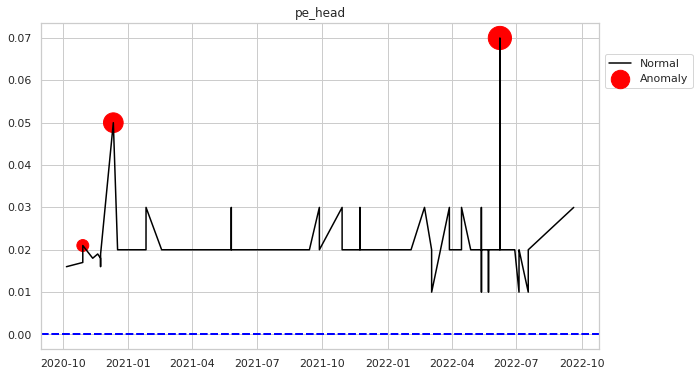

0.5


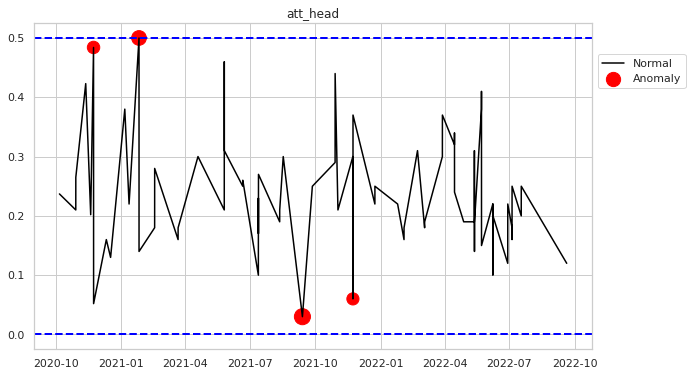

28.1


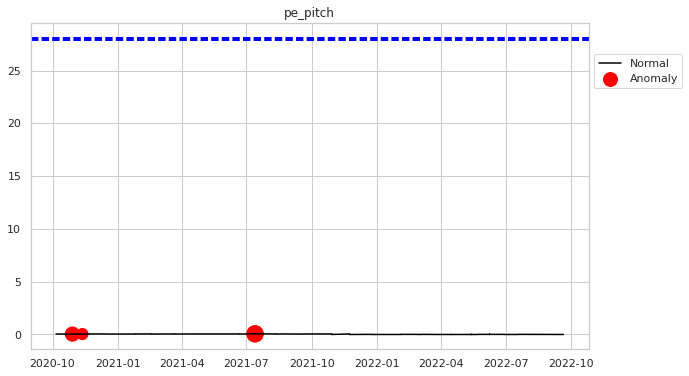

0.0


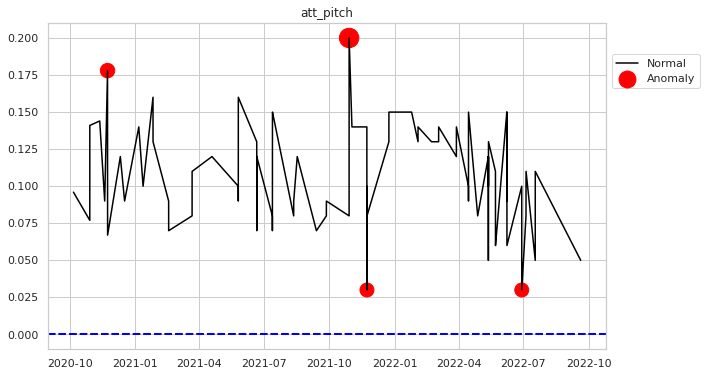

19.8


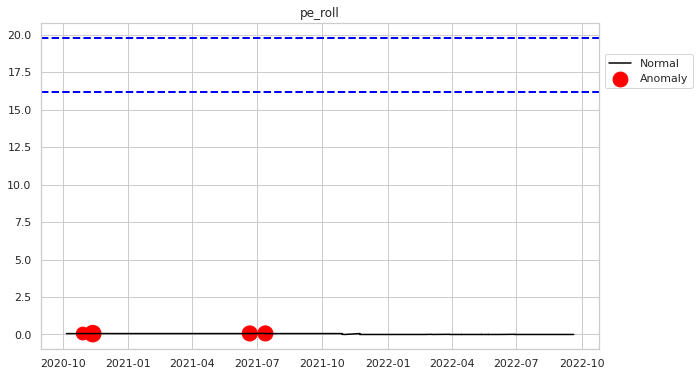

2.4


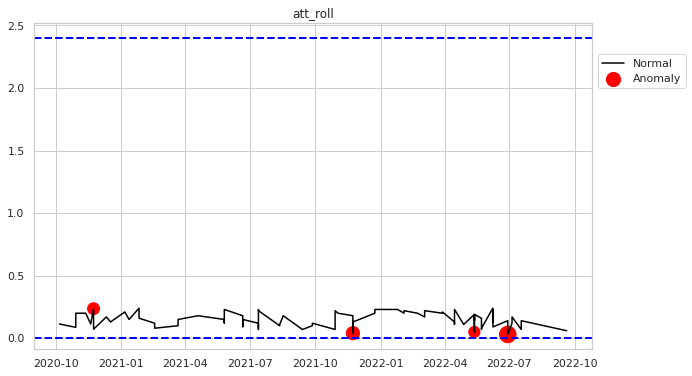

926.0


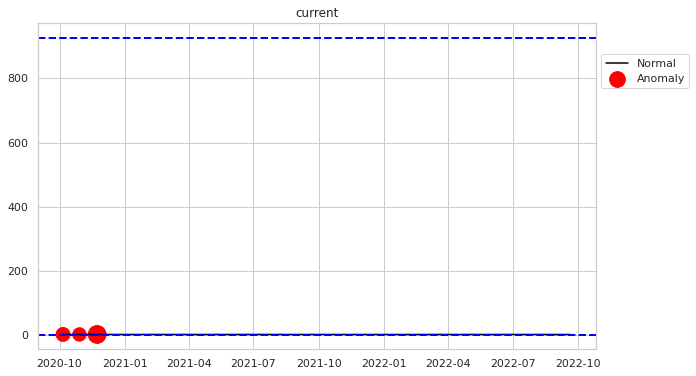

0.5


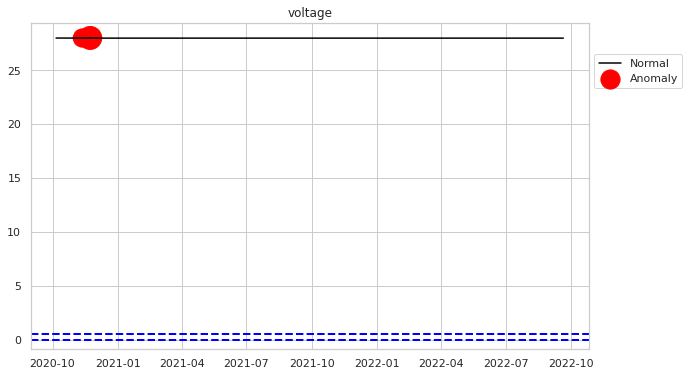

0.0


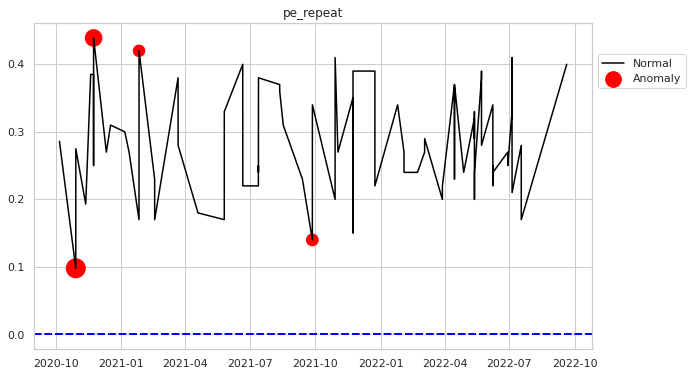

0.25


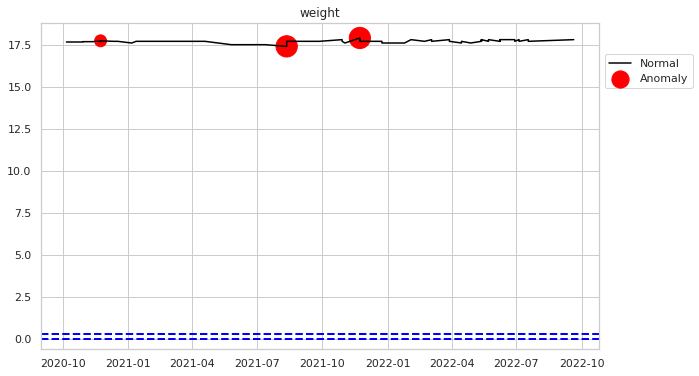

0.2


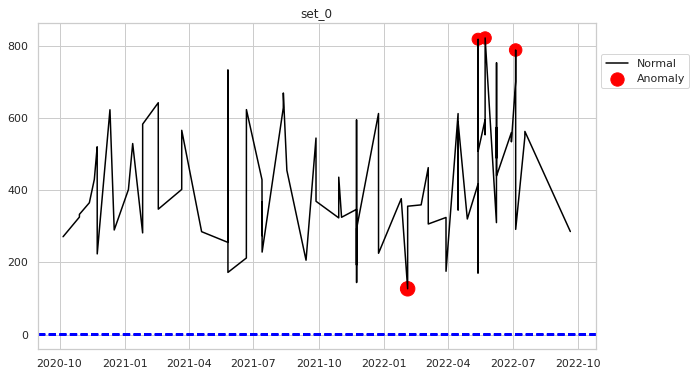

0.2


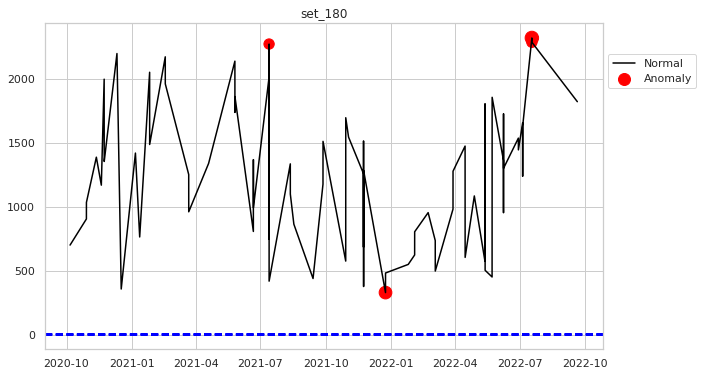

0.2


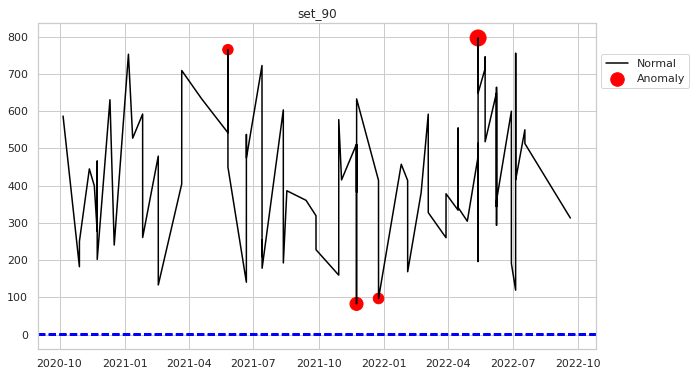

0.25


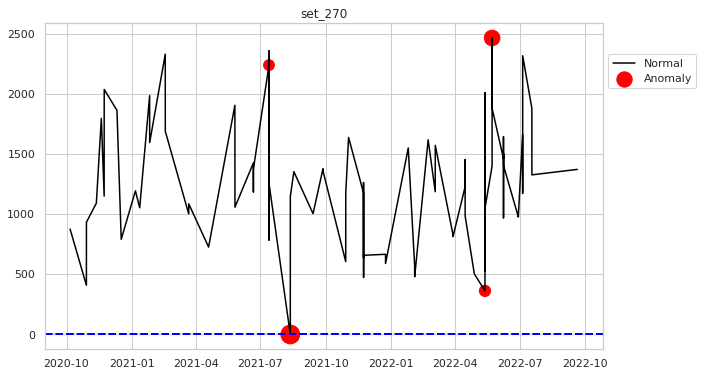

In [ ]:
# visualization
def IF_visualization(col_df, result_df):
  for col in col_df.columns[0:14]:
    fig, ax = plt.subplots(figsize=(10,6))
    inspct = result_df[result_df['col']==col].sort_index() #검사항목 별
    anomal_point = inspct.loc[inspct['pred_y']==-1, ['X']] #검사항목 별 이상치
    anomal_size = inspct.loc[inspct['pred_y']==-1]['score_samples']
    s = [((abs(n*10)**(5))/80) for n in anomal_size]

    up_lne = standard.loc[standard['검사항목']==col, ['상한값']].values[0][0]
    print(up_lne)
    down_lne = standard.loc[standard['검사항목']==col, ['하한값']].values[0][0]

    ax.plot(inspct.index, inspct['X'], color='black', label = 'Normal')
    ax.scatter(anomal_point.index, anomal_point['X'], s=s, color='red', label = 'Anomaly')

    plt.axhline(up_lne, color='blue', linestyle='--', linewidth=2)
    plt.axhline(down_lne, color='blue', linestyle='--', linewidth=2)

    plt.legend(loc=(1.01, 0.8))
    plt.title(str(col))
    plt.show()

IF_visualization(b, a)

In [ ]:
def resid_visualization(df, col, result_df): 
  fig, ax = plt.subplots(figsize=(10,6))

  x = df['date2num'].values
  f = df[col].values
  a, b = least_square_line(x,f)

  ax.plot_date(x, f, color='black',linestyle='--')
  ax.plot(x, a+b*x)

  inspct = result_df[result_df['col']==col].sort_index() #검사항목 별
  anomal_point = inspct.loc[inspct['pred_y']==-1, ['X']] #검사항목 별 이상치
  ax.scatter(anomal_point.index, anomal_point['X'], s=100, c='red', label = 'Anomaly')

  plt.legend(loc=(1.01, 0.8))
  plt.title(col)

# resid_visualization(df_num, 'pe_head', isolation_result)

In [ ]:
for col in df_num.loc[:,'pe_head':'set_270'].columns:
  resid_visualization(df_num.loc[:,'pe_head':'date2num'], col, isolation_result)

## (7) 응용 모델

### 333

In [ ]:
def _isolation_forest(df,columns,ratio):
  group_result = pd.DataFrame()
  
  group = df[[columns, 'datetime_num']].set_index('datetime_num')
  outliers_fraction = float(ratio) # 이상치 비율설정

  #표준화
  scaler = StandardScaler()
  np_scaled = scaler.fit_transform(group.values.reshape(-1, 1))
  data = pd.DataFrame(np_scaled)

  # 학습 및 예측
  model = IsolationForest(contamination=outliers_fraction)
  IF_model = model.fit(data)

  group_result.index = group.index
  group_result['X'] = group[columns]
  group_result['score_samples'] = model.score_samples(data)
  
  group_result['pred_y'] = model.predict(data)
  group_result['decision_function'] = model.decision_function(data)
  group_result['score_samples'] = model.score_samples(data)
  group_result['offset'] = model.decision_function(data) - model.score_samples(data)
  group_result['col'] = str(columns)

  return group_result

### smoothing tool

In [ ]:
def moving_avarage_smoothing(X,k): # k=window size
	S = np.zeros(X.shape[0])
	for t in range(X.shape[0]):
		if t < k:
			S[t] = np.median(X[:t+1])
		else:
			S[t] = np.sum(X[t-k:t])/k
	return S

def exponential_smoothing(X,a):
	S = np.zeros(X.shape[0])
	S[0] = X[0]
	for t in range(1,X.shape[0]):
		S[t] = a * X[t-1] + (1- a) * S[t-1]
	return S

Text(0.5, 1.0, 'pe_head (savgol_filter)')

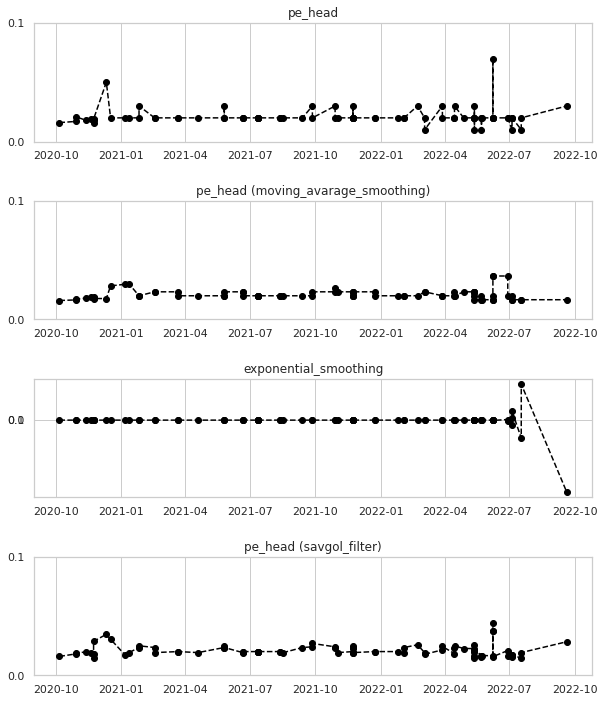

In [ ]:
fig, ax = plt.subplots(figsize=(10,12), nrows=4)
plt.subplots_adjust(hspace=0.5)
x = df_num['date2num'].values

f1 = df_num['pe_head'].values
f2 = moving_avarage_smoothing(df_num['pe_head'], 3)
# f3 = signal.savgol_filter(df_num['pe_head'], window_length=81, polyorder=3, mode="constant", cval=df_num['pe_head'].mean())
f3 = exponential_smoothing(df_num['pe_head'], 3)
f4 = signal.savgol_filter(df_num['pe_head'], window_length=5, polyorder=3, mode="nearest")

ax[0].plot_date(x, f1, color='black',linestyle='--')
ax[0].set_yticks([0, 0.1])
ax[0].set_title("pe_head")

ax[1].plot_date(x, f2, color='black',linestyle='--')
ax[1].set_yticks([0, 0.1])
ax[1].set_title("pe_head (moving_avarage_smoothing)")

ax[2].plot_date(x, f3, color='black',linestyle='--')
ax[2].set_yticks([0, 0.1])
ax[2].set_title("exponential_smoothing")

ax[3].plot_date(x, f4, color='black',linestyle='--')
ax[3].set_yticks([0, 0.1])
ax[3].set_title("pe_head (savgol_filter)")

Text(0.5, 1.0, 'pe_head (wrap)')

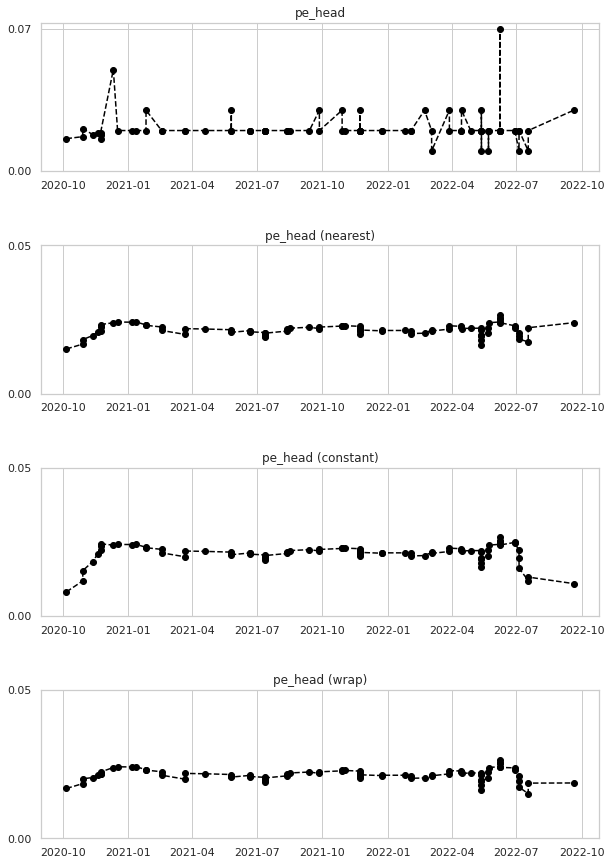

In [ ]:
fig, ax = plt.subplots(figsize=(10,15), nrows=4)
plt.subplots_adjust(hspace=0.5)
x = df_num['date2num'].values

f1 = df_num['pe_head'].values
f2 = signal.savgol_filter(df_num['pe_head'], window_length=17, polyorder=3, mode="nearest")
f3 = signal.savgol_filter(df_num['pe_head'], window_length=17, polyorder=3, mode="constant", cval=0)
f4 = signal.savgol_filter(df_num['pe_head'], window_length=17, polyorder=3, mode="wrap")

ax[0].plot_date(x, f1, color='black',linestyle='--')
ax[0].set_yticks([0, 0.07])
ax[0].set_title("pe_head")

ax[1].plot_date(x, f2, color='black',linestyle='--')
ax[1].set_yticks([0, 0.05])
ax[1].set_title("pe_head (nearest)")

ax[2].plot_date(x, f3, color='black',linestyle='--')
ax[2].set_yticks([0, 0.05])
ax[2].set_title("pe_head (constant)")

ax[3].plot_date(x, f4, color='black',linestyle='--')
ax[3].set_yticks([0, 0.05])
ax[3].set_title("pe_head (wrap)")

In [ ]:
def pnlty_data_isolation_forest(df,columns,ratio, pnlty_df):
  group_result = pd.DataFrame()
  
  group = df[[columns, 'datetime_num']].set_index('datetime_num')
  # pnlty = pnlty_df[[columns]]
  outliers_fraction = float(ratio) # 이상치 비율설정

  #표준화
  scaler = StandardScaler()
  np_scaled = scaler.fit_transform(group.values.reshape(-1, 1))
  # pnlty_np_scaled = scaler.fit_transform(pnlty.values.reshape(-1, 1))

  # data = moving_avarage_smoothing(np_scaled, 10)
  data = signal.savgol_filter(df_num['pe_head'], window_length=17, polyorder=3, mode="nearest")

  X_data = pd.DataFrame(data)
  # pnlty_data = pd.DataFrame(pnlty_np_scaled)

  # 학습 및 예측
  model = IsolationForest(contamination='auto')
  IF_model = model.fit(X_data)

  group_result.index = group.index
  group_result['X'] = group[columns]
  group_result['pred_y'] = model.predict(X_data)
  group_result['decision_function'] = model.decision_function(X_data)
  group_result['score_samples'] = model.score_samples(X_data)
  group_result['offset'] = model.decision_function(X_data) - model.score_samples(X_data)
  group_result['col'] = str(columns)

  return group_result

In [ ]:
pnlty_isolation_result = pd.DataFrame()

for col in df_num.columns[0:14]:
  df_col = pd.DataFrame()
  df_col = pnlty_data_isolation_forest(df_num, col, .05, whl_stndrd_dstnc)

  pnlty_isolation_result = pd.concat([pnlty_isolation_result,df_col], axis=0)

pnlty_isolation_result

,X,pred_y,decision_function,score_samples,offset,col
datetime_num,,,,,,
2020-10-06 00:00:00,0.016,-1,-0.257017,-0.757017,0.5,pe_head
2020-10-29 00:00:00,0.017,-1,-0.139006,-0.639006,0.5,pe_head
2020-10-29 01:00:00,0.021,-1,-0.047087,-0.547087,0.5,pe_head
2020-11-12 00:00:00,0.018,1,0.039484,-0.460516,0.5,pe_head
2020-11-19 00:00:00,0.019,1,0.054608,-0.445392,0.5,pe_head
...,...,...,...,...,...,...
2022-07-05 01:00:00,1173.600,-1,-0.001782,-0.501782,0.5,set_270
2022-07-05 02:00:00,2320.300,-1,-0.057090,-0.557090,0.5,set_270
2022-07-18 00:00:00,1882.500,-1,-0.125038,-0.625038,0.5,set_270


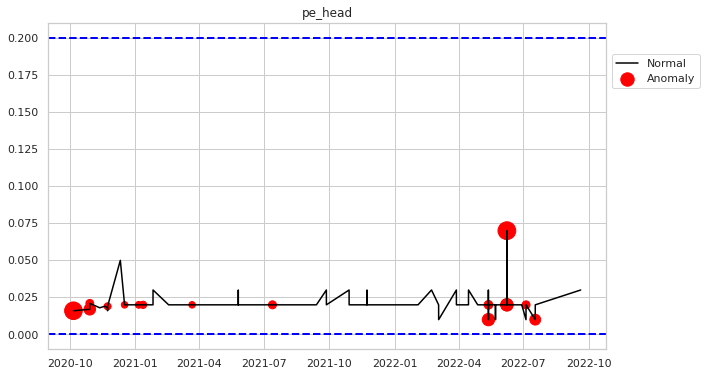

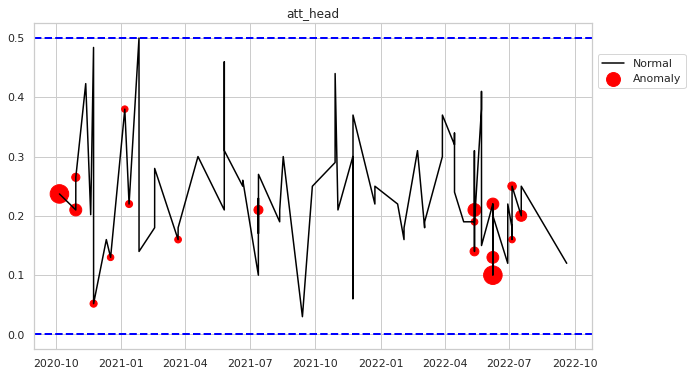

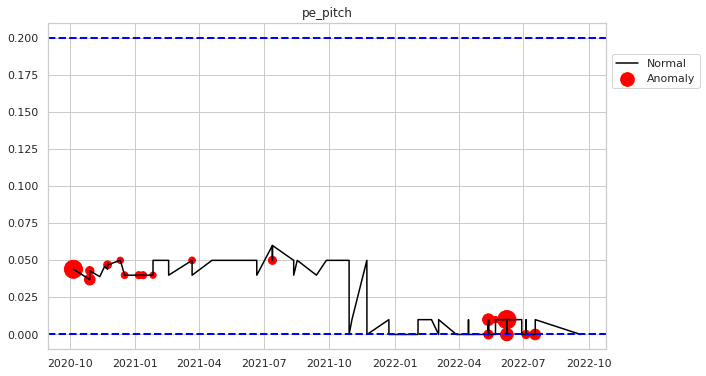

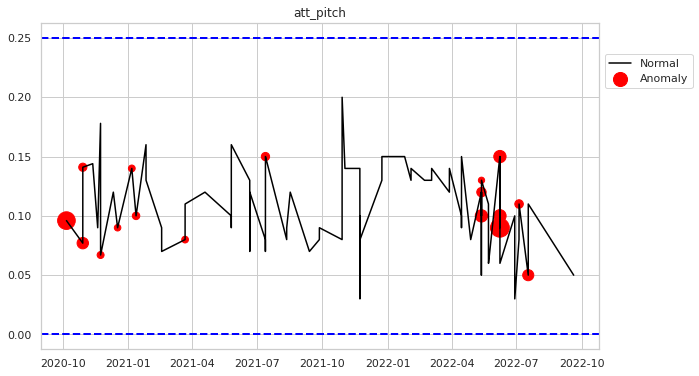

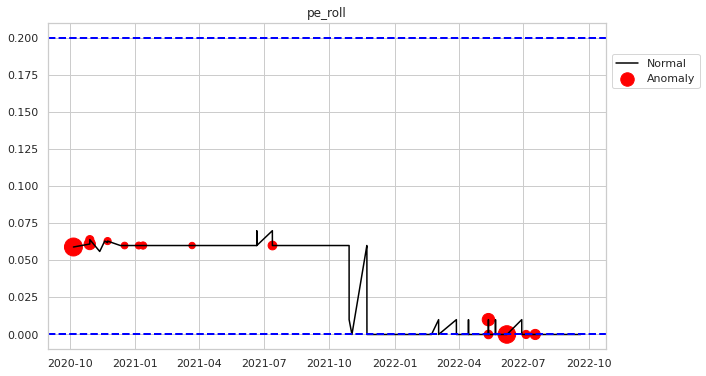

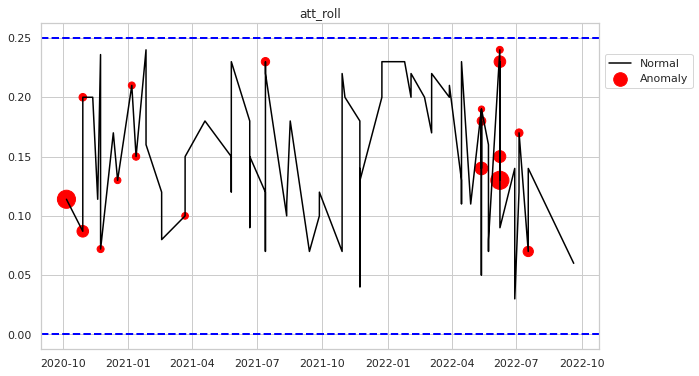

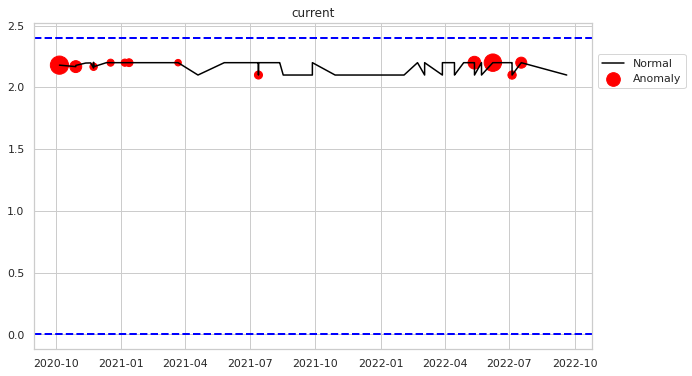

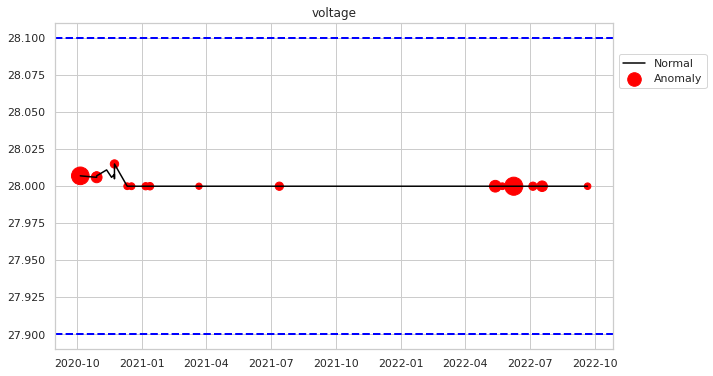

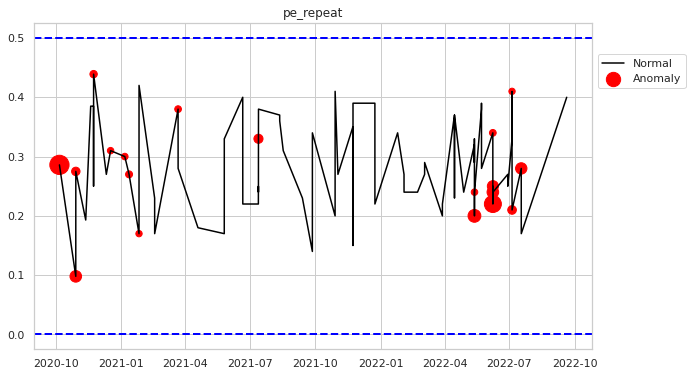

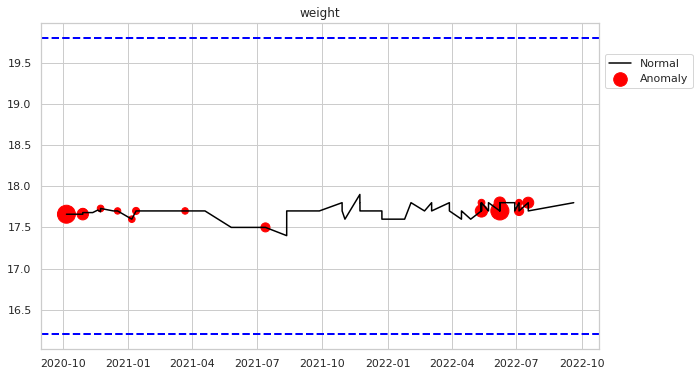

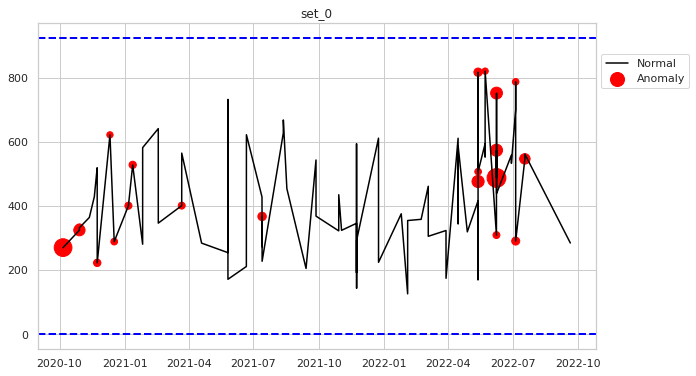

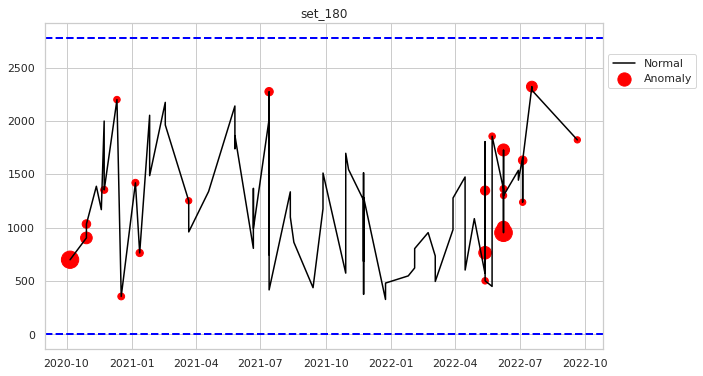

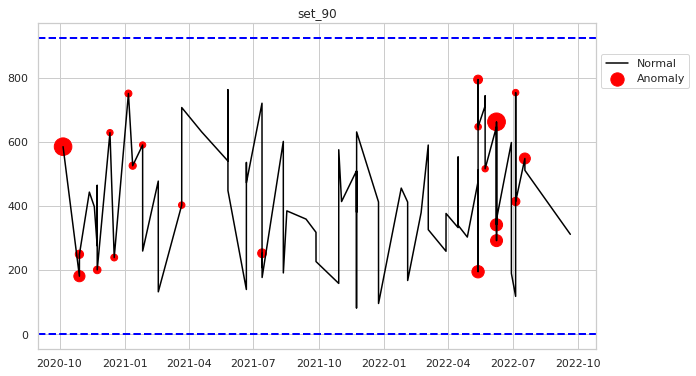

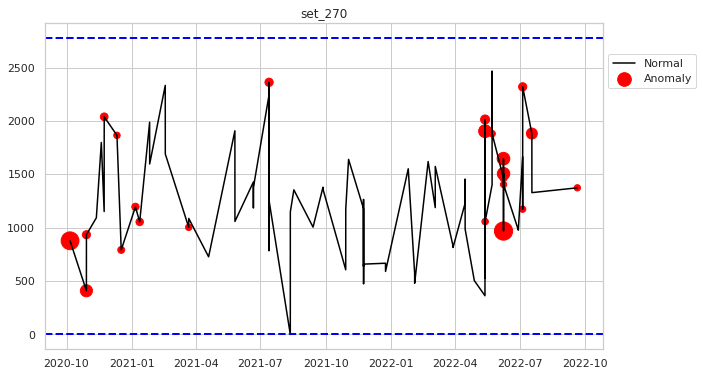

In [ ]:
# visualization
IF_visualization(df_num, pnlty_isolation_result)

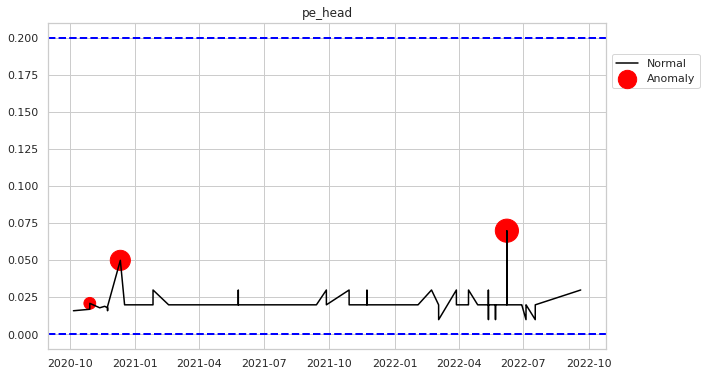

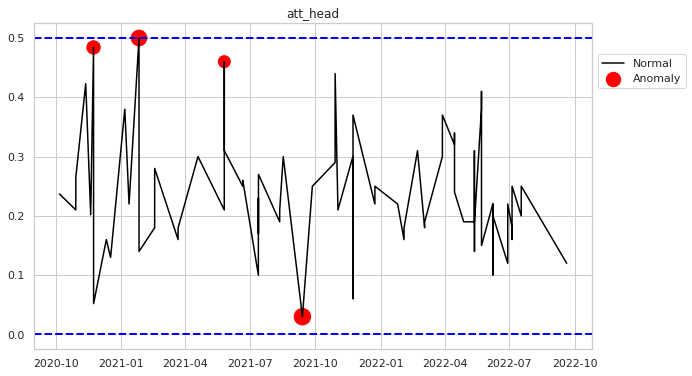

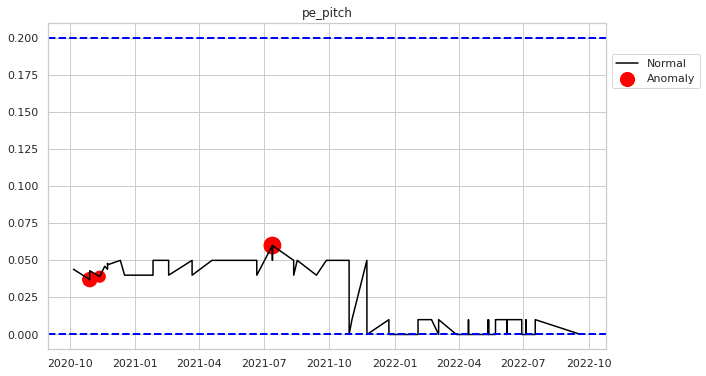

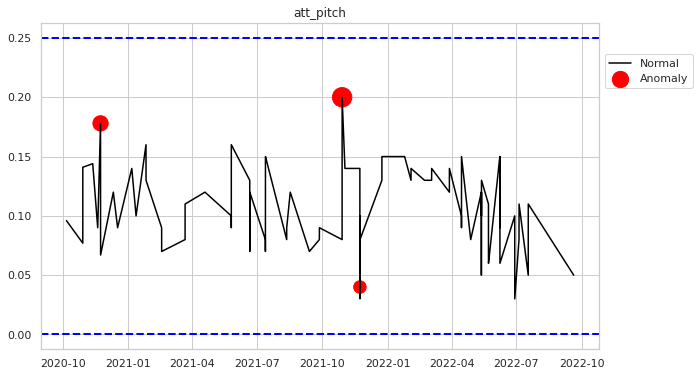

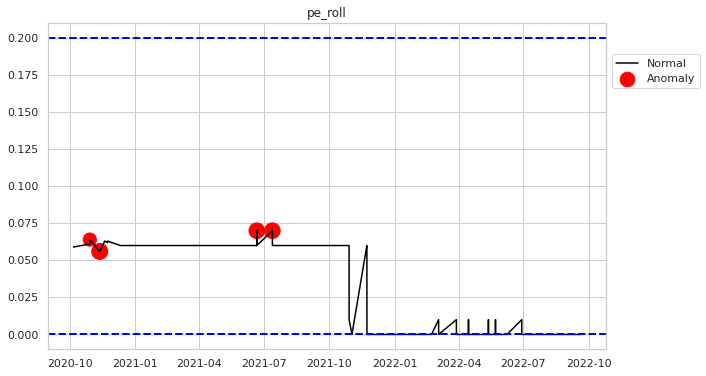

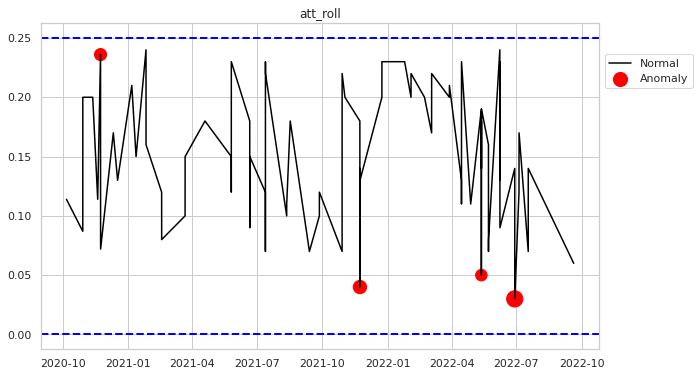

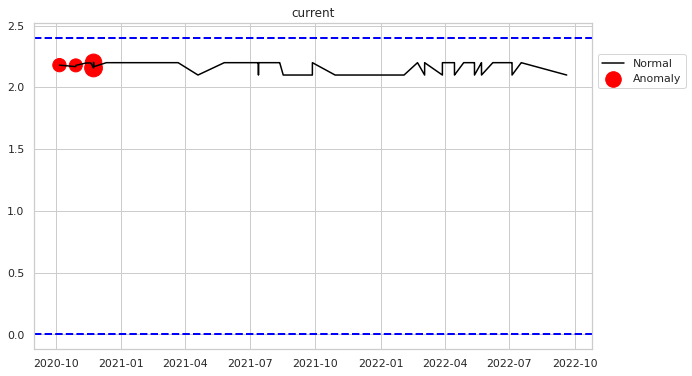

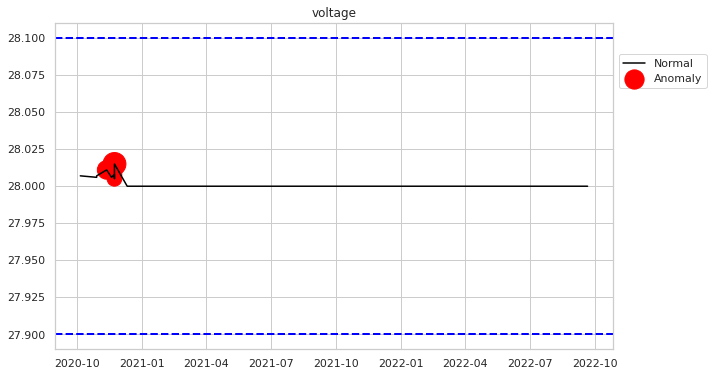

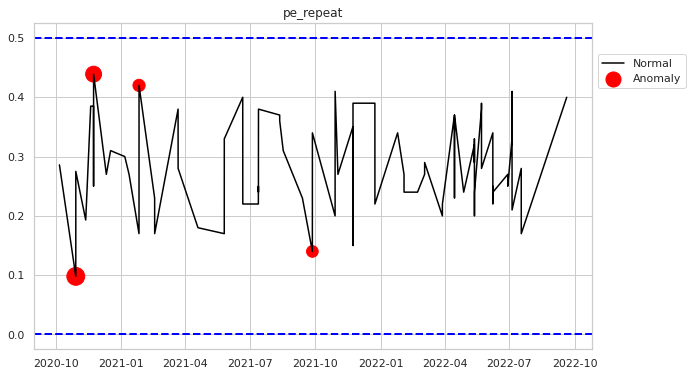

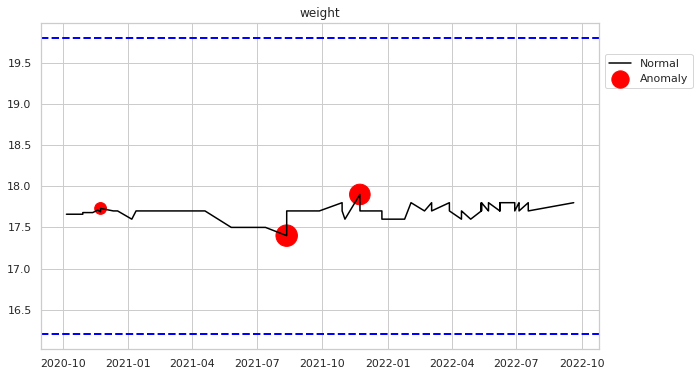

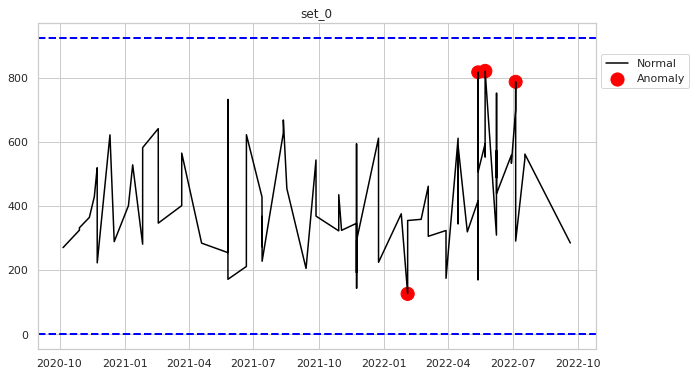

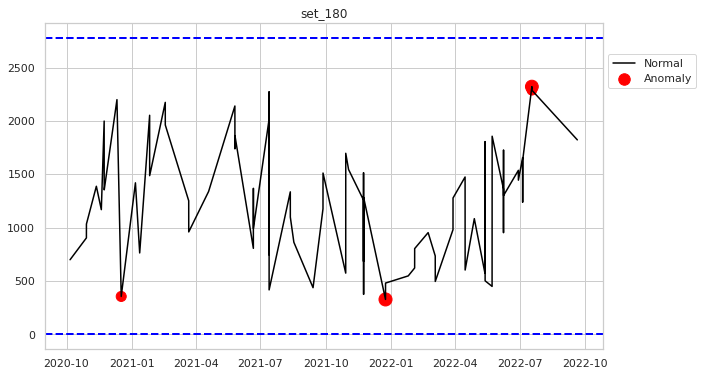

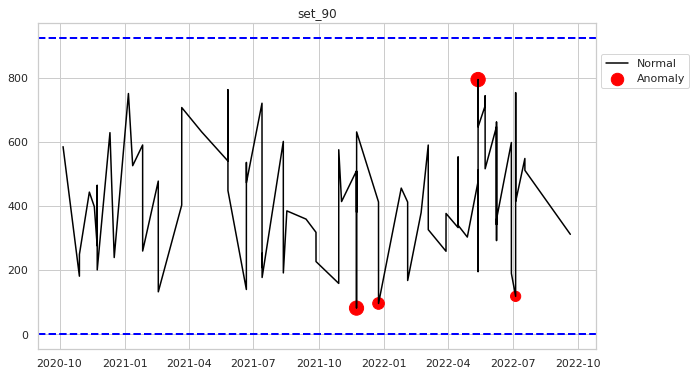

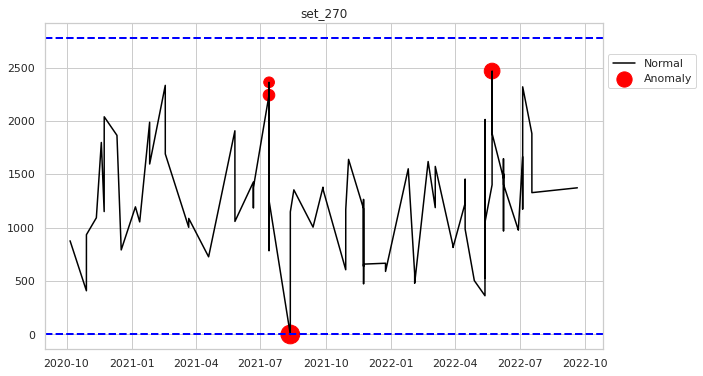

In [ ]:
IF_visualization(df_num, isolation_result)

In [ ]:
print(pnlty_isolation_result[(pnlty_isolation_result['col']=='pe_head')&(pnlty_isolation_result['pred_y']==1)]['score_samples'].mean())
pnlty_isolation_result[pnlty_isolation_result['col']=='pe_head'].sort_values(by='score_samples')

-0.422397937671005


,X,pred_y,decision_function,score_samples,offset,col
datetime_num,,,,,,
2022-09-20 00:00:00,0.030,-1,-0.192512,-0.692512,0.5,pe_head
2020-10-06 00:00:00,0.016,-1,-0.189408,-0.689408,0.5,pe_head
2022-07-18 01:00:00,0.020,-1,-0.143055,-0.643055,0.5,pe_head
2020-11-12 00:00:00,0.018,-1,-0.125838,-0.625838,0.5,pe_head
2022-07-18 00:00:00,0.010,-1,-0.119340,-0.619340,0.5,pe_head
...,...,...,...,...,...,...
2022-04-15 01:00:00,0.020,1,0.098818,-0.401182,0.5,pe_head
2021-08-12 01:00:00,0.020,1,0.099543,-0.400457,0.5,pe_head
2021-02-17 01:00:00,0.020,1,0.100678,-0.399322,0.5,pe_head


## (4) odds ratio

- 오즈(odds):  (사건 A가 일어날 확률) / (사건 A가 일어나지 않을 확률)

  $Odds = \frac{P}{1-P}$

In [ ]:
def odds_fn(P):
  return (P)/(1-P)

In [ ]:
isolation_result

,X,pred_y,decision_function,score_samples,offset,col
datetime_num,,,,,,
2020-10-06 00:00:00,0.016,1,0.027999,-0.609061,0.637060,pe_head
2020-10-29 00:00:00,0.017,1,0.027192,-0.609868,0.637060,pe_head
2020-10-29 01:00:00,0.021,-1,-0.007528,-0.644588,0.637060,pe_head
2020-11-12 00:00:00,0.018,1,0.096522,-0.540538,0.637060,pe_head
2020-11-19 00:00:00,0.019,1,0.100363,-0.536698,0.637060,pe_head
...,...,...,...,...,...,...
2022-07-05 01:00:00,1173.600,1,0.186957,-0.419608,0.606565,set_270
2022-07-05 02:00:00,2320.300,1,0.022492,-0.584073,0.606565,set_270
2022-07-18 00:00:00,1882.500,1,0.128322,-0.478242,0.606565,set_270


In [ ]:
## 이상치 개수(score_samples)

def odds_ratio_result(col_df, result_df):
  odds_result = pd.DataFrame()
  odds_raito_result = pd.DataFrame()
  odds_list=[]

  for col in col_df.columns[0:14]:
    inspct = result_df[result_df['col']==col].sort_index() #검사항목 별
    anomal_point = inspct.loc[inspct['pred_y']==-1, ['X']] #검사항목 별 이상치
    anomal_size = inspct.loc[inspct['pred_y']==-1]['score_samples']

    ##odds
    risk_P = len(anomal_point)/len(inspct)
    odds = odds_fn(risk_P)
    odds_result[col] = [odds]

  ##odds ratio
  for i in range(len(odds_result.columns)):
    odds_list = [odds_result.iloc[0,i]/(odds_result.iloc[0,j]) for j in range(len(odds_result.columns))]
    odds_raito_result[odds_result.columns[i]] = odds_list
  odds_raito_result.index = odds_result.columns

  return odds_raito_result

odds_ratio_result(df_num, isolation_result)

,pe_head,att_head,pe_pitch,att_pitch,pe_roll,att_roll,current,voltage,pe_repeat,weight,set_0,set_180,set_90,set_270
pe_head,1.000000,1.350649,1.350649,1.000000,1.350649,1.350649,1.350649,1.350649,1.350649,1.000000,1.350649,1.350649,1.350649,1.350649
att_head,0.740385,1.000000,1.000000,0.740385,1.000000,1.000000,1.000000,1.000000,1.000000,0.740385,1.000000,1.000000,1.000000,1.000000
pe_pitch,0.740385,1.000000,1.000000,0.740385,1.000000,1.000000,1.000000,1.000000,1.000000,0.740385,1.000000,1.000000,1.000000,1.000000
att_pitch,1.000000,1.350649,1.350649,1.000000,1.350649,1.350649,1.350649,1.350649,1.350649,1.000000,1.350649,1.350649,1.350649,1.350649
pe_roll,0.740385,1.000000,1.000000,0.740385,1.000000,1.000000,1.000000,1.000000,1.000000,0.740385,1.000000,1.000000,1.000000,1.000000
att_roll,0.740385,1.000000,1.000000,0.740385,1.000000,1.000000,1.000000,1.000000,1.000000,0.740385,1.000000,1.000000,1.000000,1.000000
current,0.740385,1.000000,1.000000,0.740385,1.000000,1.000000,1.000000,1.000000,1.000000,0.740385,1.000000,1.000000,1.000000,1.000000
voltage,0.740385,1.000000,1.000000,0.740385,1.000000,1.000000,1.000000,1.000000,1.000000,0.740385,1.000000,1.000000,1.000000,1.000000
pe_repeat,0.740385,1.000000,1.000000,0.740385,1.000000,1.000000,1.000000,1.000000,1.000000,0.740385,1.000000,1.000000,1.000000,1.000000
weight,1.000000,1.350649,1.350649,1.000000,1.350649,1.350649,1.350649,1.350649,1.350649,1.000000,1.350649,1.350649,1.350649,1.350649


In [ ]:
## 이상치 정도(score_samples)

def odds_ratio_score_result(col_df, result_df):
  odds_result = pd.DataFrame()
  odds_raito_result = pd.DataFrame()
  odds_list=[]

  for col in col_df.columns[0:14]:
    inspct = result_df[result_df['col']==col].sort_index() #검사항목 별

    inspct_score = np.sum(np.abs(inspct['score_samples'].values))
    anomal_score = np.sum(np.abs(inspct.loc[inspct['pred_y']==-1]['score_samples'].values))

    ##odds
    risk_P = anomal_score/inspct_score
    odds = odds_fn(risk_P)
    odds_result[col] = [odds]

  ##odds ratio
  for i in range(len(odds_result.columns)):
    odds_list = [odds_result.iloc[0,i]/(odds_result.iloc[0,j]) for j in range(len(odds_result.columns))]
    odds_raito_result[odds_result.columns[i]] = odds_list
  odds_raito_result.index = odds_result.columns

  return odds_raito_result

odds_ratio_score_result(df_num, isolation_result) #칼럼:분자, 인덱스:분모 -> pe_head가 att_head보다 이상치가 발생할 확률

,pe_head,att_head,pe_pitch,att_pitch,pe_roll,att_roll,current,voltage,pe_repeat,weight,set_0,set_180,set_90,set_270
pe_head,1.000000,1.039921,0.997091,0.775572,1.061308,0.949472,1.121691,1.206478,1.009950,0.902992,0.975546,0.897549,0.944006,1.016831
att_head,0.961611,1.000000,0.958814,0.745798,1.020566,0.913023,1.078630,1.160162,0.971179,0.868327,0.938096,0.863093,0.907767,0.977795
pe_pitch,1.002918,1.042956,1.000000,0.777834,1.064405,0.952242,1.124963,1.209998,1.012897,0.905627,0.978392,0.900167,0.946761,1.019797
att_pitch,1.289372,1.340845,1.285621,1.000000,1.368421,1.224223,1.446276,1.555598,1.302201,1.164292,1.257842,1.157274,1.217175,1.311072
pe_roll,0.942233,0.979849,0.939492,0.730769,1.000000,0.894624,1.056894,1.136783,0.951609,0.850829,0.919192,0.845700,0.889474,0.958091
att_roll,1.053217,1.095263,1.050153,0.816845,1.117788,1.000000,1.181383,1.270682,1.063697,0.951046,1.027462,0.945313,0.994243,1.070943
current,0.891511,0.927102,0.888918,0.691431,0.946168,0.846465,1.000000,1.075588,0.900382,0.805028,0.869710,0.800175,0.841592,0.906516
voltage,0.828859,0.861948,0.826448,0.642840,0.879675,0.786979,0.929724,1.000000,0.837107,0.748453,0.808590,0.743941,0.782448,0.842809
pe_repeat,0.990148,1.029676,0.987267,0.767930,1.050852,0.940118,1.110640,1.194591,1.000000,0.894096,0.965935,0.888706,0.934706,1.006812
weight,1.107429,1.151640,1.104208,0.858891,1.175324,1.051473,1.242193,1.336089,1.118449,1.000000,1.080349,0.993972,1.045420,1.126068
